# Wind Plant Asset Valuation Example

This notebook walks through a full discounted‑cash‑flow (DCF) valuation workflow for a 100 MW wind farm using the building blocks provided in the `renewables-valuation` repository. We start from external CSV inputs (production & revenues; model parameters), build annual cash‑flow objects, assemble them into an `Enterprise`, inspect intermediate tables (EBITDA, EBIT, NOPLAT, FCFF), and finally aggregate everything—operating performance, debt service, taxes, and equity returns—into a single valuation table. We conclude with diagnostic plots and core valuation metrics (Project / Equity NPV & IRR, DSCR, and LCOE).

**Conventions**

- Currency: EUR.
- Cash *outflows* are negative; cash *inflows* positive.  
- Taxes applied at the EBIT level (25%) to derive NOPLAT.  
- Debt: 50% leverage, straight‑line principal, 3% annual interest on BOY balance.  
- Inflation (CPI) escalates *fixed* OPEX only; *variable* OPEX scales with production (demand growth).  
- Revenues already include price escalation, so we take them as given.

Adjust any of these in the parameter section below if your case differs.


In [1]:
import pandas as pd, numpy as np, copy
import matplotlib.pyplot as plt
import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))

#from renewablesValuation import project, general
import src.valuation_dcf as vd

## 1. Load input data

We load two user‑prepared CSV files:

- **`wind_production_data.csv`**: Annual *actual / forecast* revenues (EUR) and net generation (MWh). These values already include price and inflation effects from the upstream energy model.
- **`wind_parameters.csv`**: Project‑level assumptions (start year, lifetime, CAPEX, fixed & variable O&M, tax rate, inflation, discount rates, etc.).

**Important modeling choices**

- We **do not recompute energy price**; annual revenue is taken as authoritative.
- Fixed OPEX is inflated each year by CPI.
- Variable OPEX is a flat €/MWh multiplied by annual production.
- The model horizon equals the number of rows in the production CSV (should match lifetime; we assert or trust input).

After loading, we convert the parameters table to a Python `dict` and keep the data frames for downstream use.


In [2]:
# Parameters from Energy simulations
prod_csv=r"../data/wind_example/wind_production_data.csv"
param_csv = r"../data/wind_example/wind_parameters.csv"

production = pd.read_csv(prod_csv)                         # year, revenue_eur, production_mwh
params = (pd.read_csv(param_csv)
            .set_index("key")["value"]
            .astype(float)
            .to_dict())

params["total_debt"] = 25_000_000
params["interest_rate"] = 0.03
print(params)

{'start_year': 2019.0, 'lifetime_years': 21.0, 'startup_year': 2019.0, 'capacity_MW': 100.0, 'net_capacity_factor': 0.3, 'power_price': 65.0, 'capex_total': 50000000.0, 'opex_fixed': 1000000.0, 'variable_opex_per_mwh': 3.0, 'discount_rate': 0.0613, 'inflation_rate': 0.02, 'income_tax': 0.25, 'total_debt': 25000000, 'interest_rate': 0.03}


# 2. Cash Flow Building Blocks

In this section we translate raw inputs into the reusable cash‑flow primitives defined in `valuation_dcf.py`:

- **Revenues**: annual nominal cash inflows from the production CSV.
- **Production (Quantity)**: energy output in MWh; used to scale variable OPEX.
- **Fixed OPEX**: escalated by CPI each year starting from the base fixed O&M €/yr in parameters.
- **Variable OPEX**: €/MWh * annual production (no CPI; demand drives change).
- **Depreciation**: straight‑line over the model lifetime (book only; non‑cash).
- **CapEx**: treated as sunk / pre‑COD outlay; for reporting we may hold as zero in the forward table if spent fully at start.
- **Debt schedule**: 50% of total investment financed; straight‑line principal; annual interest = 3% * beginning‑of‑year (BOY) debt balance.

Each element is represented as a `CashFlow` (or related class) aligned on the same timeline (start date = first model year, yearly frequency, `nper` = number of modeled years). These will later be combined into an `Enterprise` object.


In [110]:
years = production["year"].values
start_date = f"{int(years[0])}-01-01"
nper = len(years)

### 2.1 Revenues

Create an annual `CashFlow` for operating revenues using the EUR values provided in `production_data.csv`. We treat these as *already escalated*—no further price or inflation adjustments are applied here.


In [111]:
# Revenues
rev_cf = vd.CashFlow(
    name = "Revenues",
    value = 0,
    effective_date = start_date,
    nper = nper
)

rev_cf.value = production["revenue_eur"].values

C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:636: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.final_date = pd.date_range(


### 2.2 Production (Quantity Series), OPEX & Depreciation

Store annual net generation (MWh) as a `Quantity` (or simple NumPy array) so we can compute variable OPEX as €/MWh × MWh. Demand growth is therefore captured through this series.

* Calculate fixed OPEX: Affected by CPI.
* Calculate variable OPEX: Affected by production.
* Store Depreciation: Equipment/lifetime (simplification).


In [112]:
# Production
prod_qty = vd.Quantity(
    name = "Production",
    value = production["production_mwh"].values,
    effective_date = start_date,
    nper = nper
)

# Fixed OPEX - Affected by inflation
CPI = params["inflation_rate"]

fixed_vec = params["opex_fixed"]*(1+CPI)**np.arange(nper)

opex_fixed = vd.CashFlow(
    "Fixed OPEX",
    value=-fixed_vec,
    effective_date=start_date,
    nper=nper
    )

# Production OPEX
var_vec = -params["variable_opex_per_mwh"]*production["production_mwh"].values

opex_var = vd.CashFlow(
    "Variable OPEX",
    value = var_vec,
    effective_date=start_date,
    nper=nper
)

total_opex = opex_fixed + opex_var

# Depreciation
depr_cf = vd.CashFlow(
    "Depreciation",
    value=-params["capex_total"]/nper,
    effective_date=start_date,
    nper=nper
)





### 2.3 Debt Schedule

We build a simple fixed‑rate, straight‑line debt schedule:

- Opening balance = 50% × Total CAPEX.
- Annual principal = constant = Total Debt ÷ tenor (years in model horizon).
- Interest each year = 3% × BOY balance.
- Cash outflows recorded as **negative** values.

These debt cash flows are attached to the `Enterprise` later for reporting and DSCR calculations.


In [113]:
# Debt
principal_vec = -(params["total_debt"]/nper) * np.ones(nper)           # Cash outflow
remaining_prev   = params["total_debt"] + principal_vec.cumsum()  # Debt @ Beginning of the year
interest_vec  = -(params["interest_rate"] * remaining_prev)   

interest_cf = vd.CashFlow(
    "Interest",
    value=interest_vec,
    effective_date=start_date,
    nper=nper
)

principal_cf = vd.CashFlow(
    "Principal",
    value=principal_vec,
    effective_date=start_date,
    nper=nper
)

# 3. Build Enterprise Object

`Enterprise` aggregates the operating lines needed for standard DCF reporting. We pass:

- **Operating Revenues** (the revenue CashFlow).
- **Operating Expenses** (sum of fixed + variable OPEX; both negative).
- **D&A** (book depreciation; negative).
- **CapEx** (forward capex; in this example zero after COD, but placeholder kept for completeness).

We then attach **Interest** and **Principal** cash flows to the enterprise dictionary so they are available when constructing the full reporting table (even though `Enterprise.get_table()` itself only builds up to FCFF). These extra lines will be pulled explicitly when we assemble the final summary table.


In [114]:
ent = vd.Enterprise(
        operating_revenues   = rev_cf,
        operating_expenses   = -total_opex,   # gasto ⇒ signo negativo
        depreciations        = -depr_cf,
        capex                = vd.CashFlow("CapEx", value=0, effective_date=start_date, nper=nper)
      )

# Añadimos líneas de deuda para que aparezcan en la tabla final
ent["Interest"]  = interest_cf
ent["Principal"] = principal_cf


# 4. Generate Standard Tables from Enterprise

The `Enterprise` API exposes several layered views:

- **EBITDA table** – Operating Revenues, Operating Expenses (plus optional breakdown of fixed/variable), EBITDA, and margin.
- **EBIT table** – Adds Depreciation (D&A) and computes EBIT.
- **NOPLAT table** – Applies tax rate to EBIT to produce NOPLAT.
- **FCFF table** – NOPLAT ± D&A ± CapEx ⇒ Free Cash Flow to Firm (FCFF).

> NOTE: In this version of the library, `Enterprise.get_table()` returns the NOPLAT→FCFF cascade only. To obtain full operating detail we call the specific `get_ebitda_table()`, `get_ebit_table()`, and `get_noplat_table()` methods and then merge them downstream.

We display each intermediate table to sanity‑check inputs and unit signs before calculating valuation metrics.


In [115]:
ebitda_tbl = ent.get_ebitda_table(
    start_date=start_date, nper=nper, freq="Y",
    breakdown_level=3       # 3 = max detail
)
display(ebitda_tbl.transpose())

C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:321: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  cols = pd.date_range(
C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:343: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  expired_dates = pd.date_range(
C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:321: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  cols = pd.date_range(
C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:343: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  expired_dates = pd.date_range(
C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:321: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  cols = pd.date_range(
C:\Users\jmcarmona\dev\renewables-val

,Revenues,Operating Revenues,Fixed OPEX,Variable OPEX,(Operating Expenses),EBITDA,EBITDA Margin
2019-12-31,11235111.0,11235111.0,-1.000000e+06,-658539.0,-1.658539e+06,9.576572e+06,0.852379
2020-12-31,11455920.0,11455920.0,-1.020000e+06,-659775.0,-1.679775e+06,9.776145e+06,0.853371
2021-12-31,11718387.0,11718387.0,-1.040400e+06,-658503.0,-1.698903e+06,1.001948e+07,0.855022
2022-12-31,11949422.0,11949422.0,-1.061208e+06,-658467.0,-1.719675e+06,1.022975e+07,0.856087
2023-12-31,12186966.0,12186966.0,-1.082432e+06,-658374.0,-1.740806e+06,1.044616e+07,0.857158
2024-12-31,12439160.0,12439160.0,-1.104081e+06,-659487.0,-1.763568e+06,1.067559e+07,0.858225
2025-12-31,12652048.0,12652048.0,-1.126162e+06,-657996.0,-1.784158e+06,1.086789e+07,0.858983
2026-12-31,12890172.0,12890172.0,-1.148686e+06,-657786.0,-1.806472e+06,1.108370e+07,0.859857
2027-12-31,13128878.0,13128878.0,-1.171659e+06,-657609.0,-1.829268e+06,1.129961e+07,0.860668
2028-12-31,13425733.0,13425733.0,-1.195093e+06,-658647.0,-1.853740e+06,1.157199e+07,0.861926


In [116]:
ebit_tbl = ent.get_ebit_table(
    start_date=start_date, nper=nper, freq="Y",
)
display(ebit_tbl.transpose())

C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:321: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  cols = pd.date_range(
C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:343: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  expired_dates = pd.date_range(


,EBIT
2019-12-31,7.195620e+06
2020-12-31,7.395193e+06
2021-12-31,7.638532e+06
2022-12-31,7.848795e+06
2023-12-31,8.065207e+06
2024-12-31,8.294640e+06
2025-12-31,8.486937e+06
2026-12-31,8.702748e+06
2027-12-31,8.918657e+06
2028-12-31,9.191041e+06


In [117]:
noplat_tbl = ent.get_noplat_table(
    tax_rate=params["income_tax"],
    start_date=start_date, nper=nper, freq="Y",
    #breakdown_level=3
)
display(noplat_tbl.transpose())

C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:321: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  cols = pd.date_range(
C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:343: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  expired_dates = pd.date_range(


,NOPLAT
2019-12-31,5.396715e+06
2020-12-31,5.546394e+06
2021-12-31,5.728899e+06
2022-12-31,5.886596e+06
2023-12-31,6.048906e+06
2024-12-31,6.220980e+06
2025-12-31,6.365203e+06
2026-12-31,6.527061e+06
2027-12-31,6.688993e+06
2028-12-31,6.893281e+06


In [118]:
fcff_tbl = ent.get_table(          # este método solo da la cascada final
    tax_rate=params["income_tax"],
    start_date=start_date, nper=nper, freq="Y"
)
display(fcff_tbl.transpose())

C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:321: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  cols = pd.date_range(
C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:343: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  expired_dates = pd.date_range(
C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:232: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat((table, cf), axis=0)
C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:321: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  cols = pd.date_range(
C:\Users\jmcarmona\dev\

,NOPLAT,(Depreciation),CapEx,FCFF
2019-12-31,5.396715e+06,2.380952e+06,0.0,7.777667e+06
2020-12-31,5.546394e+06,2.380952e+06,0.0,7.927347e+06
2021-12-31,5.728899e+06,2.380952e+06,0.0,8.109851e+06
2022-12-31,5.886596e+06,2.380952e+06,0.0,8.267548e+06
2023-12-31,6.048906e+06,2.380952e+06,0.0,8.429858e+06
2024-12-31,6.220980e+06,2.380952e+06,0.0,8.601932e+06
2025-12-31,6.365203e+06,2.380952e+06,0.0,8.746155e+06
2026-12-31,6.527061e+06,2.380952e+06,0.0,8.908013e+06
2027-12-31,6.688993e+06,2.380952e+06,0.0,9.069945e+06
2028-12-31,6.893281e+06,2.380952e+06,0.0,9.274233e+06


# 5. Assemble Final Cash‑Flow Table

Here we consolidate all components into the reporting structure required for analysis and presentation:

1. Start from the `Enterprise` subtables (EBITDA / EBIT / NOPLAT / FCFF) and rename columns to a consistent schema.
2. Add **Production** (MWh) from the input CSV.
3. Reconstruct **Tax** as EBIT – NOPLAT (the library's NOPLAT already net of tax).
4. Pull **Interest** & **Principal** payment series from the `Enterprise`.
5. Compute **Debt BOY** (opening balance) and **Principal remaining** (end‑of‑year balance after current payment).
6. Derive **Net Income** (≈ NOPLAT in this simplified framework), **Operating Cash Flow** (= NI + Depreciation), **FCFE** (= OCF + Principal paid), **DSCR** (= FCFF / debt service), **Dividends** (100% payout), and **Cumulative Cash** after dividends.

The resulting DataFrame is the master time‑series we’ll use for plots, valuation metrics, and scenario analysis.


In [119]:
def to_rows(tbl):
    return tbl.T.reset_index(drop=True)

df_ebitda = to_rows(ebitda_tbl)
df_ebit   = to_rows(ebit_tbl)
df_nopl   = to_rows(noplat_tbl)
df_fcff   = to_rows(fcff_tbl)

In [120]:
print("EBITDA cols:", df_ebitda.columns.tolist())
print("EBIT   cols:", df_ebit.columns.tolist())
print("NOPLAT cols:", df_nopl.columns.tolist())
print("FCFF  cols:", df_fcff.columns.tolist())

EBITDA cols: ['Revenues', 'Operating Revenues', 'Fixed OPEX', 'Variable OPEX', '(Operating Expenses)', 'EBITDA', 'EBITDA Margin']
EBIT   cols: ['EBIT']
NOPLAT cols: ['NOPLAT']
FCFF  cols: ['NOPLAT', '(Depreciation)', 'CapEx', 'FCFF']


In [121]:
# rename columns
df_ebitda = df_ebitda.rename(columns={
    "Revenues"             : "Revenue",          # usar sólo una de las dos
    "(Operating Expenses)" : "Total OPEX",
})

df_fcff   = df_fcff.rename(columns={
    "(Depreciation)" : "Depreciation"
})

In [122]:
df = (df_ebitda[["Revenue", "Total OPEX", "EBITDA"]]      # + producción más adelante
      .join(df_ebit[["EBIT"]])
      .join(df_nopl[["NOPLAT"]])
      .join(df_fcff[["Depreciation", "CapEx", "FCFF"]])
)

In [123]:
df["Production"] = production["production_mwh"]

In [124]:
df["Tax"] = df["EBIT"] - df["NOPLAT"]

In [125]:
df["Interest paid"]  = ent["Interest"].get_cf(
                       start_date=start_date, nper=nper, freq="Y"
                    ).values.transpose() 
df["Principal paid"] = ent["Principal"].get_cf(
                       start_date=start_date, nper=nper, freq="Y"
                    ).values.transpose()
principal_paid_pos = np.where(df["Principal paid"] < 0, -df["Principal paid"], df["Principal paid"])
principal_remaining_end = params["total_debt"] - principal_paid_pos.cumsum()

df["Principal remaining"]  = principal_remaining_end

bal_start = np.empty_like(principal_remaining_end, dtype=float)
bal_start[0] = params["total_debt"]
bal_start[1:] = principal_remaining_end[:-1]
df["Debt BOY"] = bal_start 


df["Net Income"]   = df["NOPLAT"]            
df["CF from Operations"] = df["Net Income"] + df["Depreciation"]
df["FCFE"]         = df["CF from Operations"] + df["Principal paid"]
df["DSCR"]         = abs(df["FCFF"] / ((df["Interest paid"] + df["Principal paid"])))
df["Dividends"]    = df["Net Income"]        # payout 100 %
df["Cumulative Cash"] = (df["FCFE"] - df["Dividends"]).cumsum()

C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:321: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  cols = pd.date_range(
C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:343: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  expired_dates = pd.date_range(
C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:321: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  cols = pd.date_range(
C:\Users\jmcarmona\dev\renewables-valuation\valuation_dcf.py:343: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  expired_dates = pd.date_range(


In [126]:
cols = ["Revenue", "Production", "Total OPEX", "Depreciation",
        "Interest paid", "Principal paid", "Debt BOY", "Principal remaining",
        "EBITDA", "EBIT", "Tax", "Net Income", "CF from Operations",
        "FCFF", "FCFE", "DSCR", "Dividends", "Cumulative Cash"]

df_final = df[cols].round(0).set_index(years)
display(df_final)

,Revenue,Production,Total OPEX,Depreciation,Interest paid,Principal paid,Debt BOY,Principal remaining,EBITDA,EBIT,Tax,Net Income,CF from Operations,FCFF,FCFE,DSCR,Dividends,Cumulative Cash
2019,11235111.0,219513,-1658539.0,2380952.0,-714286.0,-1190476.0,25000000.0,23809524.0,9576572.0,7195620.0,1798905.0,5396715.0,7777667.0,7777667.0,6587191.0,4.0,5396715.0,1190476.0
2020,11455920.0,219925,-1679775.0,2380952.0,-678571.0,-1190476.0,23809524.0,22619048.0,9776145.0,7395193.0,1848798.0,5546394.0,7927347.0,7927347.0,6736871.0,4.0,5546394.0,2380952.0
2021,11718387.0,219501,-1698903.0,2380952.0,-642857.0,-1190476.0,22619048.0,21428571.0,10019484.0,7638532.0,1909633.0,5728899.0,8109851.0,8109851.0,6919375.0,4.0,5728899.0,3571429.0
2022,11949422.0,219489,-1719675.0,2380952.0,-607143.0,-1190476.0,21428571.0,20238095.0,10229747.0,7848795.0,1962199.0,5886596.0,8267548.0,8267548.0,7077072.0,5.0,5886596.0,4761905.0
2023,12186966.0,219458,-1740806.0,2380952.0,-571429.0,-1190476.0,20238095.0,19047619.0,10446160.0,8065207.0,2016302.0,6048906.0,8429858.0,8429858.0,7239382.0,5.0,6048906.0,5952381.0
2024,12439160.0,219829,-1763568.0,2380952.0,-535714.0,-1190476.0,19047619.0,17857143.0,10675592.0,8294640.0,2073660.0,6220980.0,8601932.0,8601932.0,7411456.0,5.0,6220980.0,7142857.0
2025,12652048.0,219332,-1784158.0,2380952.0,-500000.0,-1190476.0,17857143.0,16666667.0,10867890.0,8486937.0,2121734.0,6365203.0,8746155.0,8746155.0,7555679.0,5.0,6365203.0,8333333.0
2026,12890172.0,219262,-1806472.0,2380952.0,-464286.0,-1190476.0,16666667.0,15476190.0,11083700.0,8702748.0,2175687.0,6527061.0,8908013.0,8908013.0,7717537.0,5.0,6527061.0,9523810.0
2027,13128878.0,219203,-1829268.0,2380952.0,-428571.0,-1190476.0,15476190.0,14285714.0,11299610.0,8918657.0,2229664.0,6688993.0,9069945.0,9069945.0,7879469.0,6.0,6688993.0,10714286.0
2028,13425733.0,219549,-1853740.0,2380952.0,-392857.0,-1190476.0,14285714.0,13095238.0,11571993.0,9191041.0,2297760.0,6893281.0,9274233.0,9274233.0,8083757.0,6.0,6893281.0,11904762.0


# 6. Visualization & Summary Metrics

We wrap up by visualizing key model outputs and computing headline valuation metrics.

**Plots**
- Revenue vs Total OPEX (operating margin trend).
- FCFF vs FCFE (project vs equity cash generation).
- Debt balance (BOY & EOY) with DSCR overlay.
- Cumulative equity cash (post dividends).

**Valuation metrics**
- **Project NPV**: discount FCFF at project WACC.
- **Project IRR**: IRR of initial total investment + FCFF stream.
- **Equity NPV**: discount FCFE at cost of equity (Ke).
- **Equity IRR**: IRR of equity investment + FCFE stream.
- **LCOE**: Present value of (CAPEX + operating costs) divided by present value of lifetime MWh (discounted at WACC).

Adapt discount rates, payout policy, or time‑zero cash conventions as needed for your reporting standard (real vs nominal, mid‑year convention, etc.).


In [127]:
# Final evaluation - visualization

# Assumptions
WACC            = params["discount_rate"]          # 0.0613 (nominal)
COST_OF_EQUITY  = 0.10                           # 10%
DEBT_SHARE      = 0.50                           # financed investment %
TOTAL_CAPEX     = params["capex_total"]            # 50,000,000
TOTAL_DEBT      = TOTAL_CAPEX * DEBT_SHARE       # 25M (should match your input)
ANNUAL_PRINC    = TOTAL_DEBT / nper              # if using straight-line, else replace

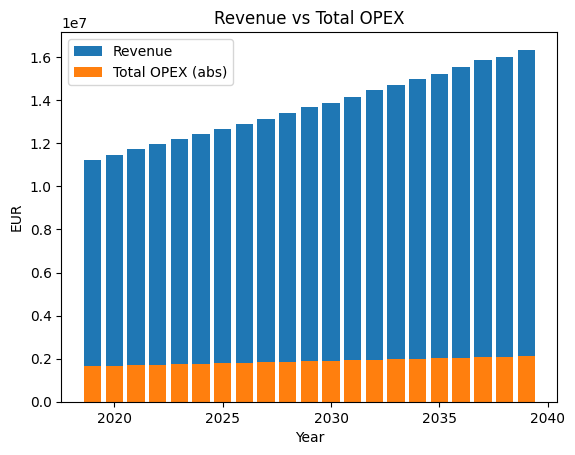

In [128]:
# Plots

# Plot 1: Revenue vs Total OPEX
plt.figure()
plt.bar(years, df_final["Revenue"], label="Revenue")
plt.bar(years, -df_final["Total OPEX"], label="Total OPEX (abs)")
plt.title("Revenue vs Total OPEX")
plt.xlabel("Year")
plt.ylabel("EUR")
plt.legend()
plt.grid(False)

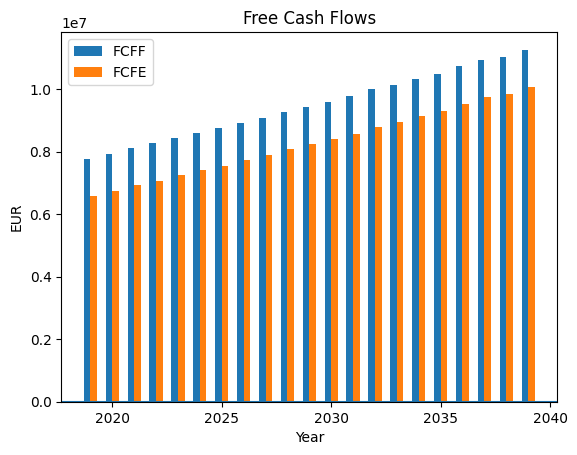

In [129]:
# Plot 2: FCFF vs FCFE
plt.figure()
plt.bar(years - 0.15, df_final["FCFF"], width=0.3, label="FCFF")
plt.bar(years + 0.15, df_final["FCFE"], width=0.3, label="FCFE")
plt.axhline(0)
plt.title("Free Cash Flows")
plt.xlabel("Year")
plt.ylabel("EUR")
plt.legend()
plt.grid(False)


Text(0.5, 1.0, 'Debt Profile & DSCR')

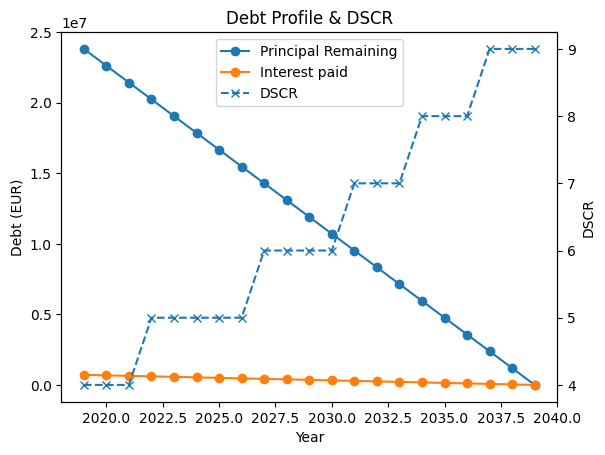

In [130]:
# Plot 3: Debt Balance vs DSCR
fig, ax1 = plt.subplots()
ax1.plot(years, df_final["Principal remaining"], marker="o", label="Principal Remaining")
ax1.plot(years, -df_final["Interest paid"], marker="o", label="Interest paid")
ax1.set_xlabel("Year")
ax1.set_ylabel("Debt (EUR)")

ax2 = ax1.twinx()
ax2.plot(years, df_final["DSCR"], linestyle="--", marker="x", label="DSCR")
ax2.set_ylabel("DSCR")


# combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper center")
plt.title("Debt Profile & DSCR")

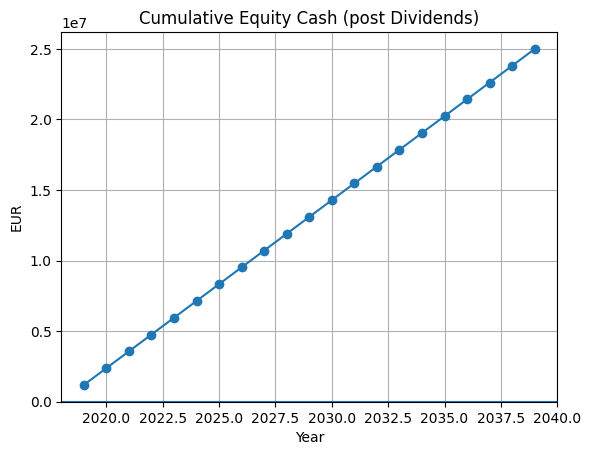

In [131]:
# Plot 4: Cumulative Equity Cash
plt.figure()
plt.plot(years, df_final["Cumulative Cash"], marker="o")
plt.axhline(0)
plt.title("Cumulative Equity Cash (post Dividends)")
plt.xlabel("Year")
plt.ylabel("EUR")
plt.grid(True)

plt.show()

In [132]:
# Valuation Metrics
# Time index t=0 at "investment date" (start of first year)
t_ops = np.arange(nper) + 1   # operating flows occur at year-end; discount from t=1,2,...

# ------------------- Project: FCFF @ WACC ---------------------------------------------
# include initial CapEx at t=0
fcff_stream = np.concatenate(([-TOTAL_CAPEX], df_final["FCFF"].values))
t_proj = np.arange(len(fcff_stream))  # 0..nper

def npv(rate, cashflows):
    t = np.arange(len(cashflows))
    return np.sum(cashflows / (1 + rate) ** t)

def irr(cashflows, guess=0.1, tol=1e-8, maxiter=100):
    r = guess
    for _ in range(maxiter):
        f = npv(r, cashflows)
        # derivative
        t = np.arange(len(cashflows))
        dfdr = -np.sum(t * cashflows / (1 + r) ** (t + 1))
        if abs(dfdr) < 1e-14:
            break
        r_new = r - f / dfdr
        if abs(r_new - r) < tol:
            r = r_new
            break
        r = r_new
    return r

In [133]:
proj_irr = irr(fcff_stream, guess=0.08)
proj_npv = npv(WACC, fcff_stream)

In [134]:
# ------------------- Equity: FCFE @ Cost of Equity ------------------------------------
equity_init = -(TOTAL_CAPEX * (1 - DEBT_SHARE))   # 50% equity
fcfe_stream = np.concatenate(([equity_init], df_final["FCFE"].values))
eq_npv_1  = npv(COST_OF_EQUITY, fcfe_stream)
eq_npv_2 = npv(WACC, fcfe_stream)
eq_irr  = irr(fcfe_stream, guess=0.12)

In [135]:
# ------------------- LCOE (CapEx + OPEX only, before financing) -----------------------
# discount rate: WACC (project perspective)
costs_ops = -df_final["Total OPEX"].values        # convert to +cost
pv_costs  = TOTAL_CAPEX + np.sum(costs_ops / (1 + WACC) ** t_ops)
pv_mwh    = np.sum(df_final["Production"].values / (1 + WACC) ** t_ops)
lcoe = pv_costs / pv_mwh

In [136]:
print("\n--- Valuation metrics ---")
print(f"Project NPV (FCFF @ WACC {WACC:.4%}): €{proj_npv:,.0f}")
print(f"Project IRR: {proj_irr*100:.2f}%")
print(f"Equity NPV  (FCFE @ Ke {COST_OF_EQUITY:.2%}): €{eq_npv_1:,.0f}")
print(f"Equity NPV_2  (FCFE @ WACC {WACC:.2%}): €{eq_npv_2:,.0f}")
print(f"Equity IRR: {eq_irr*100:.2f}%")
print(f"LCOE (PV Costs / PV MWh): €{lcoe:,.2f} per MWh")


--- Valuation metrics ---
Project NPV (FCFF @ WACC 6.1300%): €55,884,214
Project IRR: 16.58%
Equity NPV  (FCFE @ Ke 10.00%): €41,680,432
Equity NPV_2  (FCFE @ WACC 6.13%): €67,031,204
Equity IRR: 28.44%
LCOE (PV Costs / PV MWh): €28.03 per MWh
